#***Import thư viện***

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from wordcloud import WordCloud, STOPWORDS
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import LabelEncoder
import json
import os

#***Load dữ liệu***

In [62]:
data= pd.read_csv('Online_Retail.csv', encoding='latin1')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Online_Retail.csv'

### Parameters and Variables

In [ ]:
font_size = 13
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors_1 = '#E0FFE0' #màu sáng
colors_2 = '#008000' #màu tối
colors_top10 = ["#002500", "#004B00", "#007600", "#00A100", "#37FF37", "#64FF64", "#91FF91", "#BEFFBE", "#CCFFCC", "#D7FFD7"]
random_state = 42



#***Xử lý dữ liệu***

**Kiểm tra dữ liệu**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
data.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

**Xử lí giá trị null**

In [ ]:
# Kiểm tra giá trị null
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
# Lọc giá trị null
data = data.dropna()

In [ ]:
# Kiểm tra lại bộ dữ liệu
data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

**Xử lí thông tin lỗi của các thuộc tính**

In [ ]:
# Mô tả dữ liệu -> có giá trị âm và uinitPrice = 0
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
# Tạo danh sách các giá trị tuyệt đối từ các giá trị âm
negative_values = data[data.Quantity < 0]['Quantity'].abs().unique()

# Lọc các dòng có Quantity âm
negative_entries = data[data.Quantity < 0]

# Lọc các dòng có Quantity dương tương ứng với các giá trị âm
for _, row in negative_entries.iterrows():
    # Kiểm tra nếu có dòng tương ứng với Quantity dương
    matching_positive = data[
        (data['Description'] == row['Description']) &
        (data['Quantity'] == -row['Quantity'])
    ]

    # Loại bỏ các dòng tương ứng
    if not matching_positive.empty:
        data = data.drop(matching_positive.index)

# Loại bỏ các dòng Quantity âm sau khi đã xử lý
data = data[data.Quantity >= 0]

# Lọc các bản ghi có giá trị <= 0 trong cột 'UnitPrice'
cs_df = data[data.UnitPrice > 0]

In [ ]:
cs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222836 entries, 1 to 541905
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    222836 non-null  object 
 1   StockCode    222836 non-null  object 
 2   Description  222836 non-null  object 
 3   Quantity     222836 non-null  int64  
 4   InvoiceDate  222836 non-null  object 
 5   UnitPrice    222836 non-null  float64
 6   CustomerID   222836 non-null  float64
 7   Country      222836 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 15.3+ MB


In [ ]:
cs_df.describe()

,Quantity,UnitPrice,CustomerID
count,222836.000000,222836.000000,222836.000000
mean,15.842674,2.470899,15321.917608
std,53.299682,8.499814,1708.762092
min,1.000000,0.001000,12347.000000
25%,2.000000,0.850000,14030.000000
50%,6.000000,1.650000,15211.000000
75%,12.000000,2.950000,16839.000000
max,4800.000000,1599.260000,18287.000000


In [ ]:
# Kiểm tra tính duy nhất -> có sự khác biệt giữa StockCode & Description
cs_df.nunique()

InvoiceNo      17630
StockCode       3638
Description     3850
Quantity         289
InvoiceDate    16507
UnitPrice        358
CustomerID      4276
Country           37
dtype: int64

In [ ]:
#Lọc Description không phải tên sản phẩm
cs_df = cs_df[cs_df['Description'].apply(lambda x: x.isupper() and x.replace(' ', '').isalpha())]

In [ ]:
cs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162558 entries, 1 to 541902
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    162558 non-null  object 
 1   StockCode    162558 non-null  object 
 2   Description  162558 non-null  object 
 3   Quantity     162558 non-null  int64  
 4   InvoiceDate  162558 non-null  object 
 5   UnitPrice    162558 non-null  float64
 6   CustomerID   162558 non-null  float64
 7   Country      162558 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 11.2+ MB


In [ ]:
cs_df.nunique()

InvoiceNo      16914
StockCode       2723
Description     2848
Quantity         257
InvoiceDate    15882
UnitPrice        320
CustomerID      4204
Country           37
dtype: int64

In [ ]:
# Xử lý một Stockcode có nhiều Description
mode_desc = cs_df.groupby('StockCode')['Description'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
mode_desc_df = mode_desc.reset_index()

# Gán lại giá trị Description cho các StockCode trong cs_df
cs_df = cs_df.merge(mode_desc_df, on='StockCode', how='left', suffixes=('', '_mode'))

# Xử lý một Description có nhiều StockCode
# Lấy StockCode đầu tiên cho mỗi Description
unique_stockcode = cs_df.drop_duplicates(subset=['Description'], keep='first')[['Description', 'StockCode']]

# Gán lại giá trị StockCode cho các Description trong cs_df
cs_df = cs_df.merge(unique_stockcode, on='Description', how='left', suffixes=('', '_unique'))

# Cập nhật các cột Description và StockCode mới
cs_df['Description'] = cs_df['Description_mode']
cs_df['StockCode'] = cs_df['StockCode_unique']

# Loại bỏ các cột không cần thiết
cs_df = cs_df.drop(columns=['Description_mode', 'StockCode_unique'])

# In kết quả để kiểm tra
print(cs_df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365     71053                  WHITE METAL LANTERN         6   
1    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
2    536366     22632            HAND WARMER RED RETROSPOT         6   
3    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   
4    536367     22749    FELTCRAFT PRINCESS CHARLOTTE DOLL         8   

    InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/10 8:26       3.39     17850.0  United Kingdom  
1  12/1/10 8:26       3.39     17850.0  United Kingdom  
2  12/1/10 8:28       1.85     17850.0  United Kingdom  
3  12/1/10 8:34       1.69     13047.0  United Kingdom  
4  12/1/10 8:34       3.75     13047.0  United Kingdom  


In [ ]:
cs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162558 entries, 0 to 162557
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    162558 non-null  object 
 1   StockCode    162558 non-null  object 
 2   Description  162558 non-null  object 
 3   Quantity     162558 non-null  int64  
 4   InvoiceDate  162558 non-null  object 
 5   UnitPrice    162558 non-null  float64
 6   CustomerID   162558 non-null  float64
 7   Country      162558 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 11.2+ MB


In [ ]:
cs_df.nunique()

InvoiceNo      16914
StockCode       2708
Description     2708
Quantity         257
InvoiceDate    15882
UnitPrice        320
CustomerID      4204
Country           37
dtype: int64

**Xử lí giá trị Description duy nhất trong từng hoá đơn**

In [ ]:
# Kiểm tra có sự trùng lặp thuộc tính trong cùng một hoá đơn
# Nhóm dữ liệu theo 'InvoiceNo' và 'Description', sau đó đếm số lượng xuất hiện của mỗi 'Description' trong mỗi 'InvoiceNo'
description_counts = cs_df.groupby(['InvoiceNo', 'Description']).size().reset_index(name='counts')

# Lọc ra các 'InvoiceNo' và 'Description' có 'counts' lớn hơn 1 (tức là cùng sản phẩm xuất hiện hơn một lần trong cùng một hóa đơn)
duplicate_descriptions = description_counts[description_counts['counts'] > 1]

# Lấy các dòng từ cs_df tương ứng với các InvoiceNo và Description này
result = cs_df.merge(duplicate_descriptions[['InvoiceNo', 'Description']], on=['InvoiceNo', 'Description'], how='inner')

print("Các dòng trùng lặp chi tiết:")
print(result)


Các dòng trùng lặp chi tiết:
     InvoiceNo StockCode                     Description  Quantity  \
0       536381     71270                 PHOTO CLIP LINE         1   
1       536381     71270                 PHOTO CLIP LINE         3   
2       536409     21866     UNION JACK FLAG LUGGAGE TAG         1   
3       536409     21866     UNION JACK FLAG LUGGAGE TAG         1   
4       536412     21738  COSY SLIPPER SHOES SMALL  RED          1   
...        ...       ...                             ...       ...   
6669    581471     21411     GINGHAM HEART  DOORSTOP RED         2   
6670    581514    17091J          VANILLA INCENSE IN TIN        66   
6671    581514    17091J          VANILLA INCENSE IN TIN        24   
6672    581538     23349     ROLL WRAP VINTAGE CHRISTMAS         3   
6673    581538     23349     ROLL WRAP VINTAGE CHRISTMAS         1   

        InvoiceDate  UnitPrice  CustomerID         Country  
0      12/1/10 9:41       1.25     15311.0  United Kingdom  
1      1

In [ ]:
cs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162558 entries, 0 to 162557
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    162558 non-null  object 
 1   StockCode    162558 non-null  object 
 2   Description  162558 non-null  object 
 3   Quantity     162558 non-null  int64  
 4   InvoiceDate  162558 non-null  object 
 5   UnitPrice    162558 non-null  float64
 6   CustomerID   162558 non-null  float64
 7   Country      162558 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 11.2+ MB


In [ ]:
# Gộp Quantity của các sản phẩm giống nhau trong cùng một hoá đơn
data = cs_df.groupby(['InvoiceNo', 'Description'], as_index=False).agg({
    'Quantity': 'sum',
    'StockCode': 'first',  # Giữ lại StockCode của dòng xuất hiện đầu tiên
    'UnitPrice': 'first', # Giữ lại UnitPrice của dòng xuất hiện đầu tiên
    'Country': 'first', # Giữ lại Country của dòng xuất hiện đầu tiên
    'CustomerID': 'first', # Giữ lại CustomerID của dòng xuất hiện đầu tiên
    'InvoiceDate': 'first' # Giữ lại InvoiceDate của dòng xuất hiện đầu tiên
})

**Kiểm tra lại thông tin**

In [ ]:
# Kiểm tra tổng số lượng Quantity trước và sau khi gộp
total_quantity_before = cs_df['Quantity'].sum()
total_quantity_after = data['Quantity'].sum()
print(f"Tổng số lượng trước khi gộp: {total_quantity_before}")
print(f"Tổng số lượng sau khi gộp: {total_quantity_after}")

# Kiểm tra số lượng dòng trước và sau khi gộp
num_rows_before = len(cs_df)
num_rows_after = len(data)
print(f"Số lượng dòng trước khi gộp: {num_rows_before}")
print(f"Số lượng dòng sau khi gộp: {num_rows_after}")

# Kiểm tra xem còn dòng nào trùng lặp không
duplicate_check = data[data.duplicated(subset=['InvoiceNo', 'Description'], keep=False)]
print("Các dòng bị trùng lặp sau khi gộp (nếu có):")
print(duplicate_check)

Tổng số lượng trước khi gộp: 2497969
Tổng số lượng sau khi gộp: 2497969
Số lượng dòng trước khi gộp: 162558
Số lượng dòng sau khi gộp: 159060
Các dòng bị trùng lặp sau khi gộp (nếu có):
Empty DataFrame
Columns: [InvoiceNo, Description, Quantity, StockCode, UnitPrice, Country, CustomerID, InvoiceDate]
Index: []


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159060 entries, 0 to 159059
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    159060 non-null  object 
 1   Description  159060 non-null  object 
 2   Quantity     159060 non-null  int64  
 3   StockCode    159060 non-null  object 
 4   UnitPrice    159060 non-null  float64
 5   Country      159060 non-null  object 
 6   CustomerID   159060 non-null  float64
 7   InvoiceDate  159060 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 9.7+ MB


In [ ]:
data.nunique()

InvoiceNo      16914
Description     2708
Quantity         259
StockCode       2708
UnitPrice        320
Country           37
CustomerID      4204
InvoiceDate    15882
dtype: int64

In [ ]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,159060.000000,159060.000000,159060.000000
mean,15.704571,2.651222,15298.437596
std,51.186281,9.634123,1707.515913
min,1.000000,0.001000,12347.000000
25%,2.000000,0.850000,13985.000000
50%,6.000000,1.650000,15159.000000
75%,12.000000,3.250000,16813.000000
max,4300.000000,1599.260000,18287.000000


**Tạo cột Total Price**




In [ ]:
data['TotalPrice'] = data.apply(lambda row: row['UnitPrice'] * row['Quantity'], axis = 1)
data.head(10)

,InvoiceNo,Description,Quantity,StockCode,UnitPrice,Country,CustomerID,InvoiceDate,TotalPrice
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,84029G,3.39,United Kingdom,17850.0,12/1/10 8:26,20.34
1,536365,WHITE METAL LANTERN,6,71053,3.39,United Kingdom,17850.0,12/1/10 8:26,20.34
2,536366,HAND WARMER RED RETROSPOT,6,22632,1.85,United Kingdom,17850.0,12/1/10 8:28,11.10
3,536367,ASSORTED COLOUR BIRD ORNAMENT,32,84879,1.69,United Kingdom,13047.0,12/1/10 8:34,54.08
4,536367,DOORMAT NEW ENGLAND,4,48187,7.95,United Kingdom,13047.0,12/1/10 8:34,31.80
5,536367,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,22749,3.75,United Kingdom,13047.0,12/1/10 8:34,30.00
6,536367,IVORY KNITTED MUG COSY,6,22310,1.65,United Kingdom,13047.0,12/1/10 8:34,9.90
7,536367,RECIPE BOX WITH METAL HEART,4,21777,7.95,United Kingdom,13047.0,12/1/10 8:34,31.80
8,536368,BLUE COAT RACK PARIS FASHION,3,22914,4.95,United Kingdom,13047.0,12/1/10 8:34,14.85
9,536368,YELLOW COAT RACK PARIS FASHION,3,22912,4.95,United Kingdom,13047.0,12/1/10 8:34,14.85


#***EDA***

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159060 entries, 0 to 159059
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    159060 non-null  object 
 1   Description  159060 non-null  object 
 2   Quantity     159060 non-null  int64  
 3   StockCode    159060 non-null  object 
 4   UnitPrice    159060 non-null  float64
 5   Country      159060 non-null  object 
 6   CustomerID   159060 non-null  float64
 7   InvoiceDate  159060 non-null  object 
 8   TotalPrice   159060 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 10.9+ MB


In [ ]:
data['CustomerID'] = data['CustomerID'].astype(str)
categorical_vars = []
continuous_vars = []
for col in data.columns:
  if data[col].dtype == 'object' or data[col].nunique() <= 11:
    categorical_vars.append(col)
  else:
    continuous_vars.append(col)
print("Biến liên tục:", continuous_vars)
print("Biến phân loại:", categorical_vars)

Biến liên tục: ['Quantity', 'UnitPrice', 'TotalPrice']
Biến phân loại: ['InvoiceNo', 'Description', 'StockCode', 'Country', 'CustomerID', 'InvoiceDate']


In [ ]:
data.describe()

,Quantity,UnitPrice,TotalPrice
count,159060.000000,159060.000000,159060.000000
mean,15.704571,2.651222,26.803861
std,51.186281,9.634123,89.720089
min,1.000000,0.001000,0.001000
25%,2.000000,0.850000,4.950000
50%,6.000000,1.650000,11.800000
75%,12.000000,3.250000,21.000000
max,4300.000000,1599.260000,7144.720000


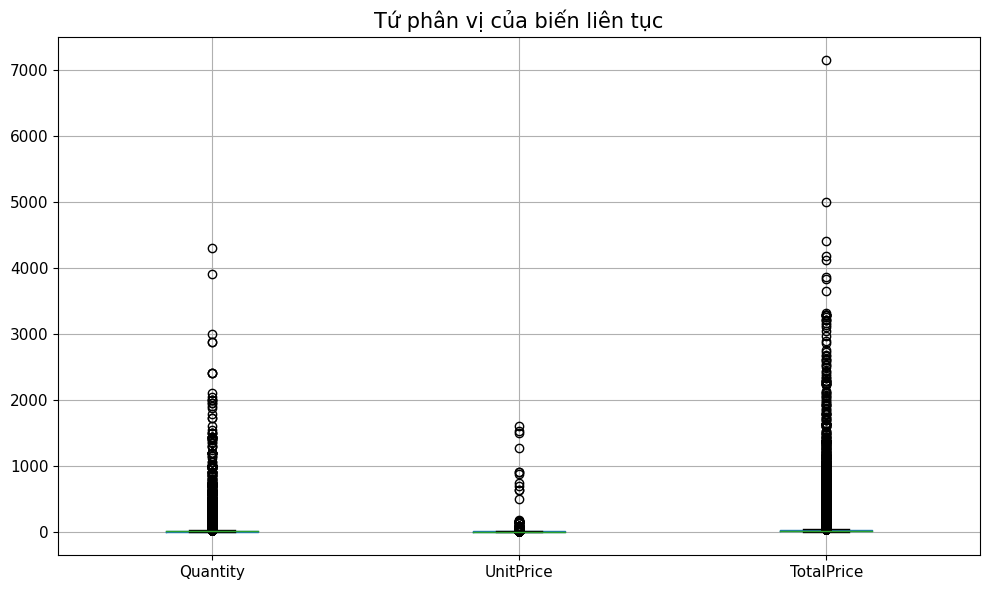

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
data.boxplot(ax=ax)
ax.set_title('Tứ phân vị của biến liên tục')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

Số lượng hóa đơn duy nhất: 16914
Tổng số sản phẩm: 2497969
InvoiceNo
576339    264
580727    253
579196    252
578270    211
573576    202
567656    194
567183    188
575607    164
571441    159
572552    156
Name: StockCode, dtype: int64


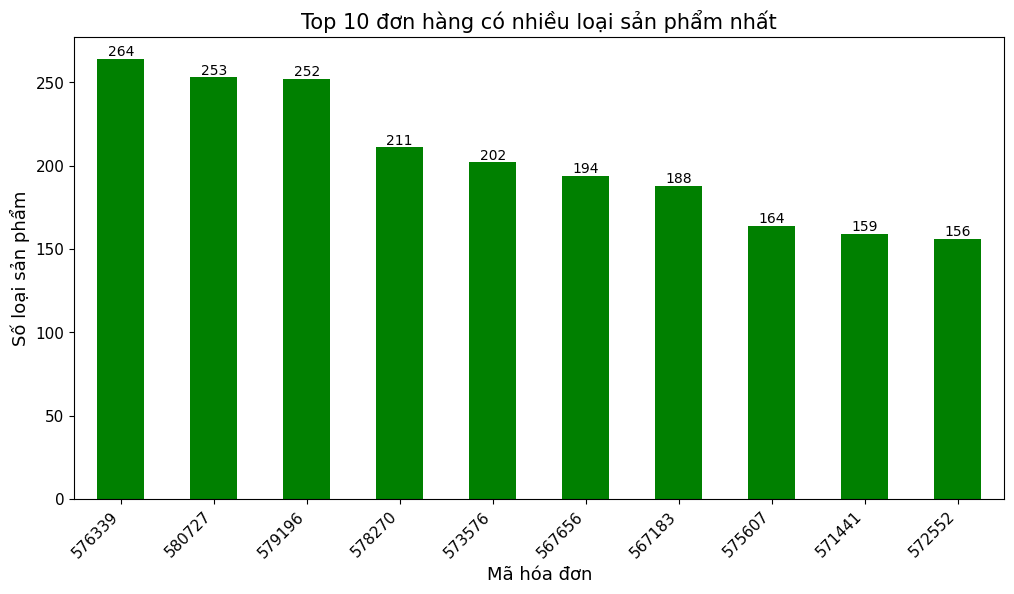

In [ ]:
# Đếm số lượng hóa đơn duy nhất
num_invoices = data['InvoiceNo'].nunique()
print(f"Số lượng hóa đơn duy nhất: {num_invoices}")

# Đếm tổng số sản phẩm
num_products = data['Quantity'].sum()
print(f"Tổng số sản phẩm: {num_products}")

# Đếm số lượng sản phẩm trong mỗi đơn hàng
product_counts = data.groupby('InvoiceNo')['StockCode'].count().sort_values(ascending=False).head(10)
print(product_counts)
# Vẽ biểu đồ cột
plt.figure(figsize=(12, 6))
ax = product_counts.plot(kind='bar', color=colors_2)
for i, v in enumerate(product_counts):
    ax.text(i, v, str(int(v)), color='black', va='bottom', ha='center', fontsize=10)
plt.xlabel('Mã hóa đơn')
plt.ylabel('Số loại sản phẩm')
plt.title('Top 10 đơn hàng có nhiều loại sản phẩm nhất')
plt.xticks(rotation=45, ha='right')
plt.show()

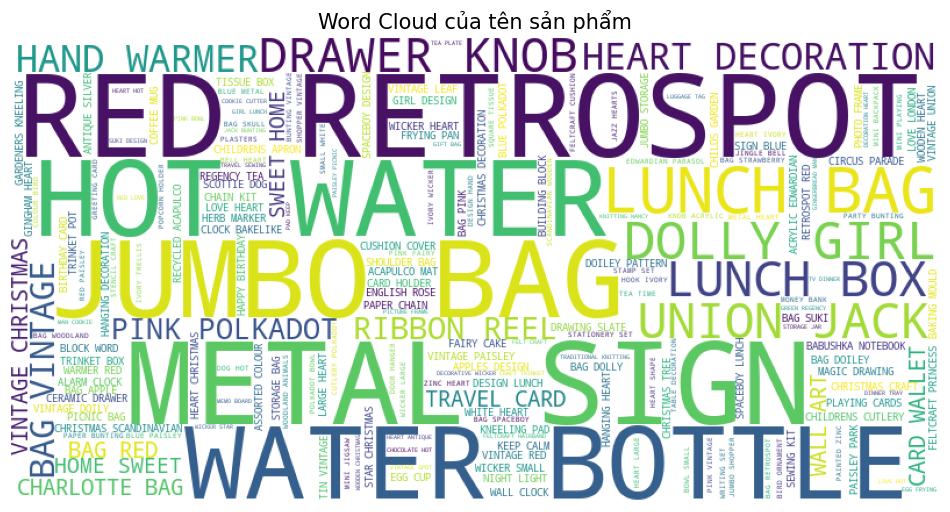

In [ ]:
# Tạo một chuỗi văn bản từ biến "Description"
text = ' '.join(data['Description'])
# Tạo word cloud
wordcloud = WordCloud(width=800, height=400,
                      stopwords=STOPWORDS,
                      background_color='white').generate(text)

# Hiển thị word cloud
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud của tên sản phẩm')
plt.show()

     StockCode                        Description  InvoiceCount
1074     22469              HEART OF WICKER SMALL           698
1204     22629                SPACEBOY LUNCH BOX            588
1608     23209          LUNCH BAG DOILEY PATTERN            555
1032     22411  JUMBO SHOPPER VINTAGE RED PAISLEY           508
878      22197                     POPCORN HOLDER           498
1075     22470              HEART OF WICKER LARGE           497
2318     84879      ASSORTED COLOUR BIRD ORNAMENT           496
814      22111       SCOTTIE DOG HOT WATER BOTTLE           470
1227     22662        LUNCH BAG DOLLY GIRL DESIGN           469
1428     22966      GINGERBREAD MAN COOKIE CUTTER           456


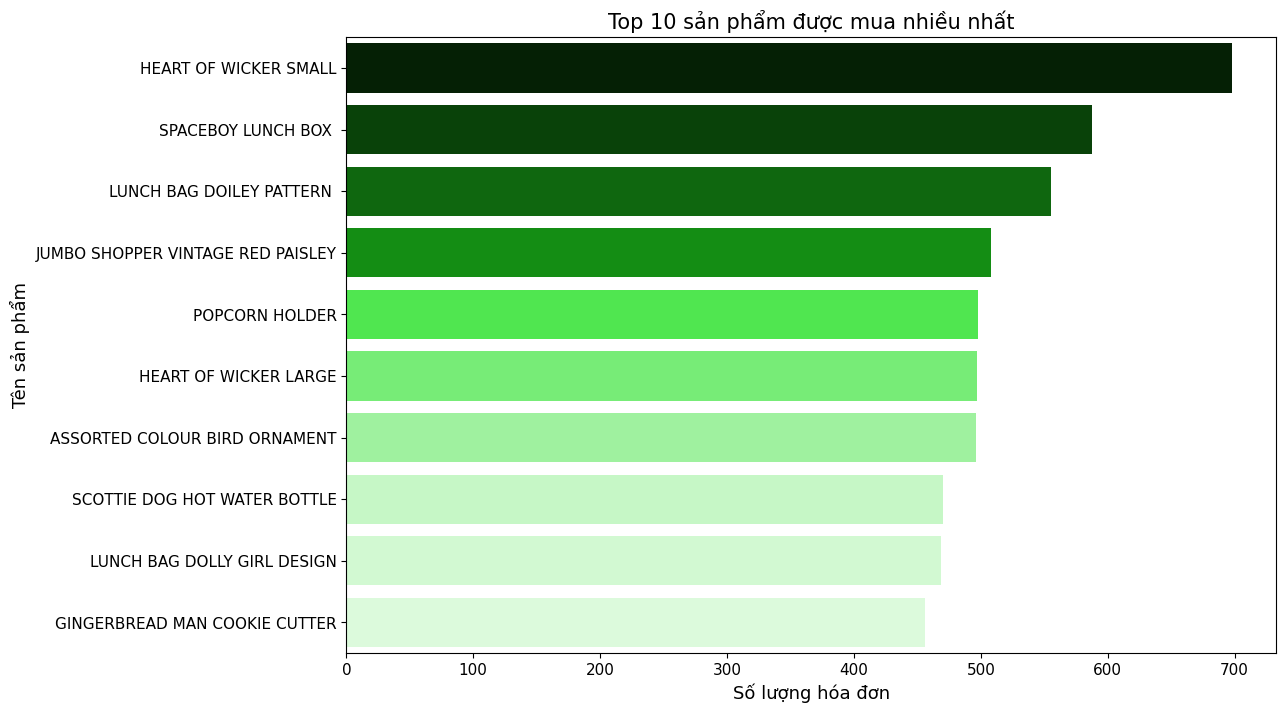

     StockCode                    Description  TotalPrice
1516     23084             RABBIT NIGHT LIGHT    45568.78
2318     84879  ASSORTED COLOUR BIRD ORNAMENT    40278.60
298      21137       BLACK RECORD COVER FRAME    37804.83
2113     79321                  CHILLI LIGHTS    37243.07
2413    85099B        JUMBO BAG RED RETROSPOT    36634.20
878      22197                 POPCORN HOLDER    31917.13
1662     23298                 SPOTTY BUNTING    27366.80
1075     22470          HEART OF WICKER LARGE    26347.68
2011     47566                  PARTY BUNTING    25766.45
2708      POST                        POSTAGE    25621.00


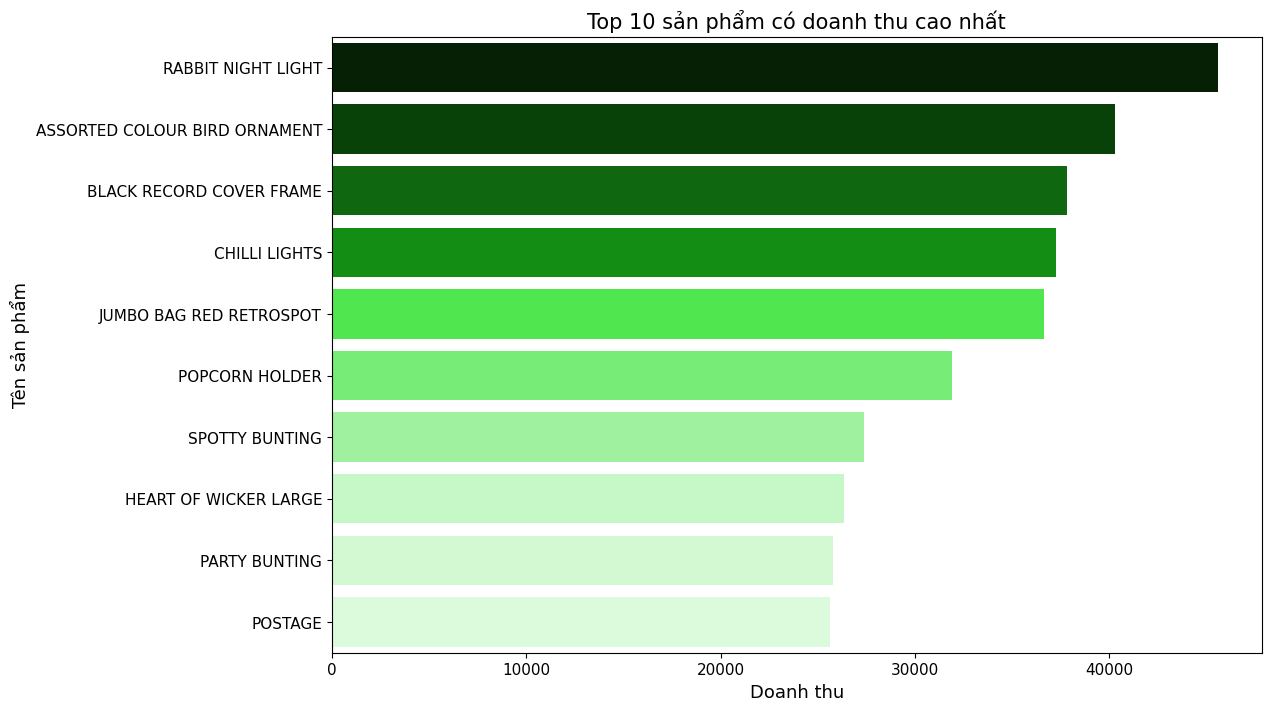

In [ ]:
grouped_Invoice = data.groupby(['StockCode', 'Description'])['InvoiceNo'].count().reset_index()
# Đổi tên các cột
grouped_Invoice.rename(columns={'InvoiceNo': 'InvoiceCount'}, inplace=True)
# Nhận 10 sản phẩm có số lượng hóa đơn cao nhất
top_10_products_invoice = grouped_Invoice.nlargest(10, 'InvoiceCount')
print(top_10_products_invoice )
# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='InvoiceCount', y='Description', data=top_10_products_invoice, palette=colors_top10)
plt.title('Top 10 sản phẩm được mua nhiều nhất')
plt.xlabel('Số lượng hóa đơn')
plt.ylabel('Tên sản phẩm')
plt.show()

grouped_TotalPrice = data.groupby(['StockCode', 'Description'])['TotalPrice'].sum().reset_index()
# Lấy top 10 sản phẩm có số lượng hóa đơn cao nhất
top_10_products_TotalPrice = grouped_TotalPrice.nlargest(10, 'TotalPrice')
print(top_10_products_TotalPrice)
# Vẽ biểu đồ cột
plt.figure(figsize=(12, 8))
sns.barplot(x='TotalPrice', y='Description', data=top_10_products_TotalPrice, palette=colors_top10)
plt.title('Top 10 sản phẩm có doanh thu cao nhất')
plt.xlabel('Doanh thu')
plt.ylabel('Tên sản phẩm')
plt.show()

           Country   TotalPrice
35  United Kingdom  3470427.633
23     Netherlands   174125.130
10            EIRE   124881.940
14         Germany    97373.710
13          France    92915.790


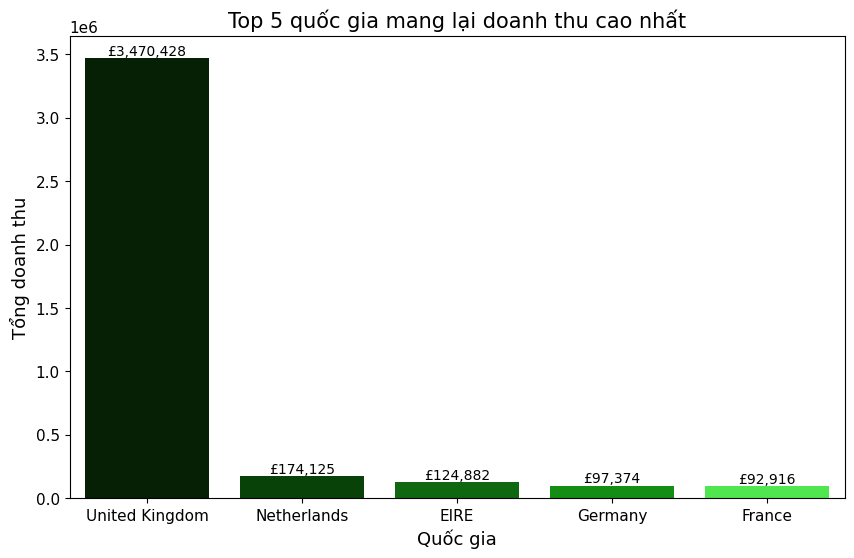

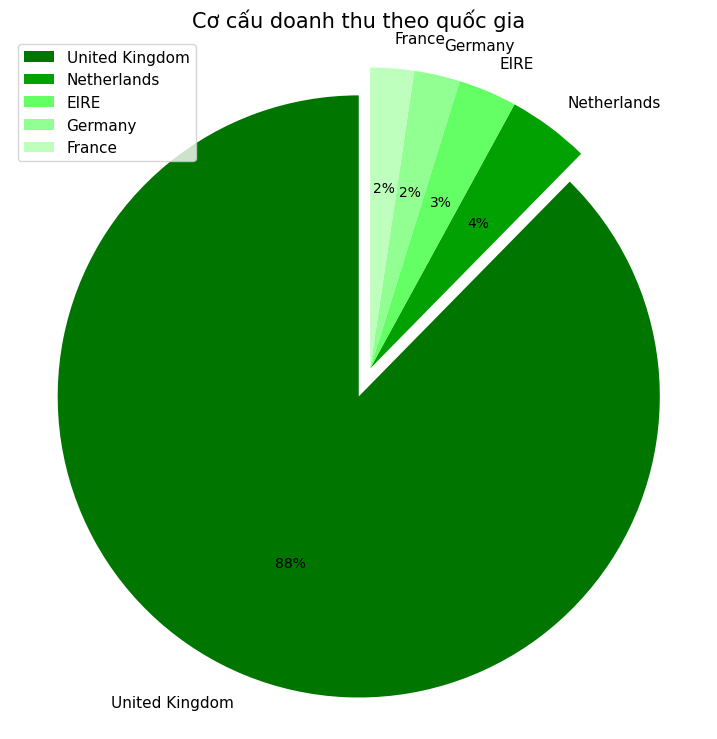

In [ ]:
# Nhóm dữ liệu theo quốc gia và tính tổng doanh thu
grouped_Country = data.groupby(['Country'], as_index=False)['TotalPrice'].sum()

# Sắp xếp theo tổng doanh thu giảm dần
Country_total_sales = grouped_Country.sort_values('TotalPrice', ascending=False)

# Lấy top 5 quốc gia có tổng doanh thu cao nhất
top_5_countries = Country_total_sales.head(5)
print(top_5_countries)
# Vẽ biểu đồ cột cho top 5 quốc gia
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Country', y='TotalPrice', data=top_5_countries, palette=colors_top10)

# Thêm giá trị của cột vào biểu đồ
for i, v in enumerate(top_5_countries['TotalPrice']):
    ax.text(i, v, f'£{v:,.0f}', color='black', ha='center', va='bottom', fontsize=10)

plt.title('Top 5 quốc gia mang lại doanh thu cao nhất')
plt.xlabel('Quốc gia')
plt.ylabel('Tổng doanh thu')
plt.show()

# Nhóm dữ liệu theo quốc gia và tính tổng doanh thu
grouped_Country = data.groupby(['Country'], as_index=False)['TotalPrice'].sum()

# Sắp xếp theo tổng doanh thu giảm dần
Country_total_sales = grouped_Country.sort_values('TotalPrice', ascending=False)

# Lấy top 5 quốc gia có tổng doanh thu cao nhất
top_5_countries = Country_total_sales.head(5)

# Tạo biểu đồ tròn
plt.figure(figsize=(9, 9))
explode = [0.1, 0, 0, 0, 0]
labels = top_5_countries['Country']
sizes = top_5_countries['TotalPrice']
colors= [ "#007600", "#00A100", "#64FF64", "#91FF91", "#BEFFBE", "#CCFFCC", "#D7FFD7"]
patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.0f%%', startangle=90)
plt.axis('equal')
plt.title('Cơ cấu doanh thu theo quốc gia')
plt.legend(patches, labels, loc="best")
plt.show()

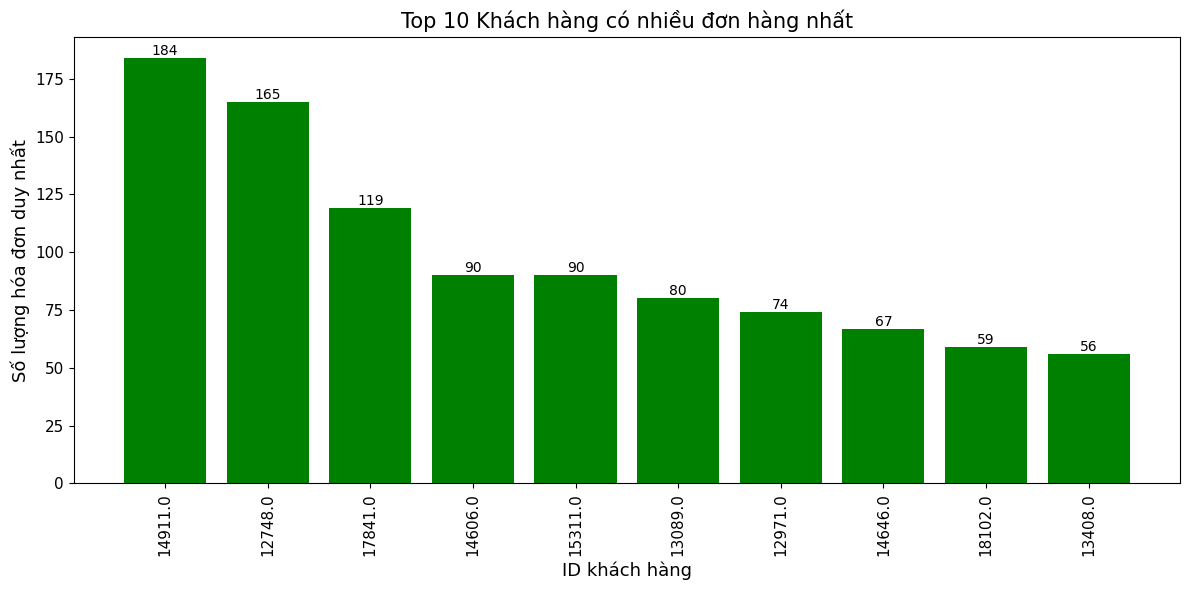

Sản phẩm được mua nhiều nhất bởi (CustomerID 14911.0):
StockCode: 22197, Description: POPCORN HOLDER
Quantity: 784, Total Price: 653.3999999999999

Sản phẩm được mua nhiều nhất bởi (CustomerID 12748.0):
StockCode: 21135, Description: VICTORIAN  METAL POSTCARD SPRING
Quantity: 591, Total Price: 140.55

Sản phẩm được mua nhiều nhất bởi (CustomerID 17841.0):
StockCode: 20668, Description: DISCO BALL CHRISTMAS DECORATION
Quantity: 1776, Total Price: 207.36

Sản phẩm được mua nhiều nhất bởi (CustomerID 14606.0):
StockCode: 22227, Description: HANGING HEART MIRROR DECORATION 
Quantity: 77, Total Price: 50.05

Sản phẩm được mua nhiều nhất bởi (CustomerID 15311.0):
StockCode: 22774, Description: RED DRAWER KNOB ACRYLIC EDWARDIAN
Quantity: 708, Total Price: 775.56

Sản phẩm được mua nhiều nhất bởi (CustomerID 13089.0):
StockCode: 84879, Description: ASSORTED COLOUR BIRD ORNAMENT
Quantity: 1148, Total Price: 1824.92

Sản phẩm được mua nhiều nhất bởi (CustomerID 12971.0):
StockCode: 40016, Descri

In [ ]:
# Nhóm dữ liệu theo CustomerID và đếm số lượng Số hóa đơn duy nhất
customer_invoice_counts = data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Sắp xếp DataFrame theo số lượng Số hóa đơn duy nhất theo thứ tự giảm dần
top_customers = customer_invoice_counts.sort_values('InvoiceNo', ascending=False).head(10)

# Tạo biểu đồ bar
plt.figure(figsize=(12, 6))
plt.bar(top_customers['CustomerID'], top_customers['InvoiceNo'], color=colors_2)
for i, value in enumerate(top_customers['InvoiceNo']):
    plt.text(i, value, str(value), ha='center', va='bottom', fontsize=10)

plt.title('Top 10 Khách hàng có nhiều đơn hàng nhất')
plt.xlabel('ID khách hàng')
plt.ylabel('Số lượng hóa đơn duy nhất')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#Tìm 3 sản phẩm hàng đầu cho khách hàng hàng đầu
for _, top_customer in top_customers.iterrows():
    top_customer_id = top_customer['CustomerID']
    top_customer_products = data[data['CustomerID'] == top_customer_id].groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(1)
    top_customer_description = data[data['CustomerID'] == top_customer_id].loc[data['StockCode'].isin(top_customer_products.index), 'Description'].values[0]
    top_customer_quantity = top_customer_products.values[0]
    top_customer_total_price = data[(data['CustomerID'] == top_customer_id) & (data['StockCode'] == top_customer_products.index[0])]['TotalPrice'].sum()

    print(f"Sản phẩm được mua nhiều nhất bởi (CustomerID {top_customer_id}):")
    print(f"StockCode: {top_customer_products.index[0]}, Description: {top_customer_description}")
    print(f"Quantity: {top_customer_quantity}, Total Price: {top_customer_total_price}")
    print()

In [ ]:
data_day=data.copy()
data_day['InvoiceDate'] = pd.to_datetime(data_day['InvoiceDate'], format='%m/%d/%y %H:%M')
data_day["Year"] = data_day["InvoiceDate"].dt.year
data_day["Month"] = data_day["InvoiceDate"].dt.month
data_day["Day"] = data_day["InvoiceDate"].dt.day
data_day["Time"] = data_day["InvoiceDate"].dt.strftime('%H:%M')
data_day['day_name'] = data_day['InvoiceDate'].dt.day_name()
data_day['weekday'] = data_day['InvoiceDate'].dt.weekday
data_day['month_name'] = data_day['InvoiceDate'].dt.month_name()
data_day['just_date'] = data_day['InvoiceDate'].dt.date

Month
1      8452
2      7741
3     10582
4      8832
5     10889
6     10495
7     10457
8     10437
9     15631
10    20041
11    26732
12    18771
Name: InvoiceNo, dtype: int64 Month
1     224267.780
2     214291.940
3     294093.260
4     206210.821
5     327785.970
6     314037.690
7     299823.021
8     323508.610
9     483041.631
10    504998.110
11    576457.050
12    494906.210
Name: TotalPrice, dtype: float64


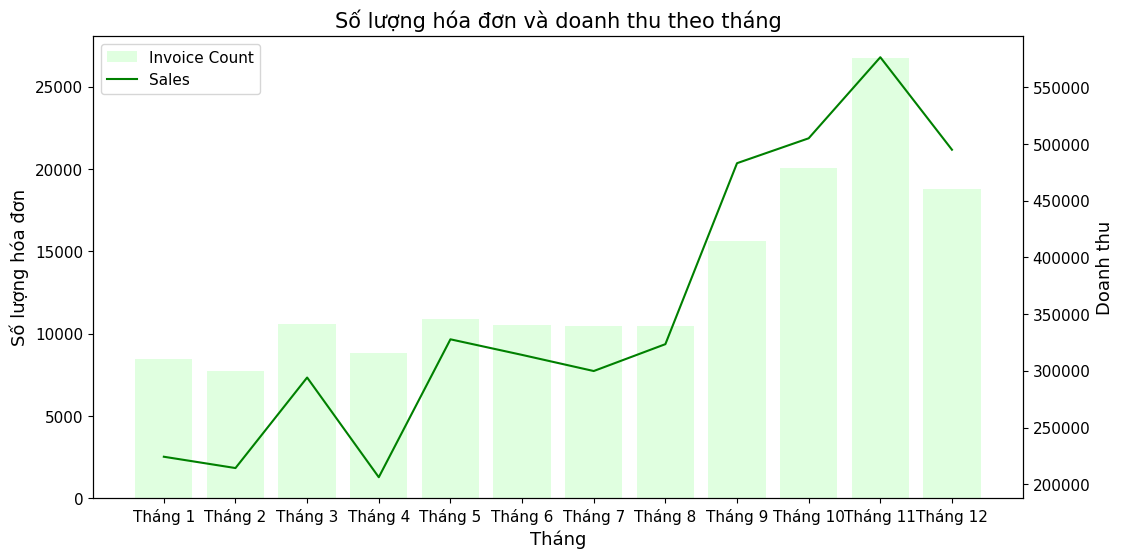

In [ ]:
colors1 = ['#1f77b4']
colors2 = ['#ff7f0e']
#Số lượng hóa đơn theo tháng
invoice_count_by_month = data_day.groupby('Month')['InvoiceNo'].count()
#Doanh thu theo tháng
sales_by_month = data_day.groupby('Month')['TotalPrice'].sum()
print(invoice_count_by_month,sales_by_month)
#Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(invoice_count_by_month.index, invoice_count_by_month, color=colors_1, label='Invoice Count')
ax2 = ax1.twinx()
ax2.plot(sales_by_month.index, sales_by_month, color=colors_2, label='Sales')
ax1.set_title('Số lượng hóa đơn và doanh thu theo tháng')
ax1.set_xlabel('Tháng')
ax1.set_ylabel('Số lượng hóa đơn')
ax2.set_ylabel('Doanh thu')
ax1.set_xticks(invoice_count_by_month.index)
ax1.set_xticklabels(['Tháng 1', 'Tháng 2', 'Tháng 3', 'Tháng 4', 'Tháng 5', 'Tháng 6', 'Tháng 7', 'Tháng 8', 'Tháng 9', 'Tháng 10', 'Tháng 11', 'Tháng 12'])
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.show()


#***Mã hoá thành dạng số theo phương pháp LabelEncoder (Thư viện scikit-learn)***




In [ ]:
new_data = data[['Description', 'StockCode']]
new_data = new_data.drop_duplicates()
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2709 entries, 0 to 155845
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  2709 non-null   object
 1   StockCode    2709 non-null   object
dtypes: object(2)
memory usage: 63.5+ KB


In [ ]:
data.head()

,InvoiceNo,Description,Quantity,StockCode,UnitPrice,Country,CustomerID,InvoiceDate,TotalPrice
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,84029G,3.39,United Kingdom,17850.0,12/1/10 8:26,20.34
1,536365,WHITE METAL LANTERN,6,71053,3.39,United Kingdom,17850.0,12/1/10 8:26,20.34
2,536366,HAND WARMER RED RETROSPOT,6,22632,1.85,United Kingdom,17850.0,12/1/10 8:28,11.10
3,536367,ASSORTED COLOUR BIRD ORNAMENT,32,84879,1.69,United Kingdom,13047.0,12/1/10 8:34,54.08
4,536367,DOORMAT NEW ENGLAND,4,48187,7.95,United Kingdom,13047.0,12/1/10 8:34,31.80


In [ ]:
transaction_data = data\
    .groupby('InvoiceNo')['Description']\
    .apply(list)\
    .reset_index()\
    .rename(columns={'Description': 'basket'})

In [ ]:
transaction_data.head(10)

,InvoiceNo,basket
0,536365,"[KNITTED UNION FLAG HOT WATER BOTTLE, WHITE ME..."
1,536366,[HAND WARMER RED RETROSPOT]
2,536367,"[ASSORTED COLOUR BIRD ORNAMENT, DOORMAT NEW EN..."
3,536368,"[BLUE COAT RACK PARIS FASHION, YELLOW COAT RAC..."
4,536369,[BATH BUILDING BLOCK WORD]
5,536370,"[ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKEL..."
6,536372,[HAND WARMER RED RETROSPOT]
7,536373,"[KNITTED UNION FLAG HOT WATER BOTTLE, RETRO CO..."
8,536374,[VICTORIAN SEWING BOX LARGE]
9,536375,"[KNITTED UNION FLAG HOT WATER BOTTLE, RETRO CO..."


In [ ]:
# QUY ĐỊNH MÃ HÓA SẢN PHẨM THEO SỐ
# Khởi tạo LabelEncoder
le = LabelEncoder()

# Fit LabelEncoder cho tất cả các Description trong dataset
all_items = [item for sublist in transaction_data['basket'] for item in sublist]
le.fit(all_items)

# Mã hóa từng giao dịch
transaction_data['basket_encoded'] = transaction_data['basket'].apply(lambda x: le.transform(x).tolist())

# Chuyển đổi danh sách các mã hóa thành chuỗi, mỗi mã cách nhau bởi dấu cách
transaction_data['basket_encoded_str'] = transaction_data['basket_encoded'].apply(lambda x: ' '.join(map(str, x)))

In [ ]:
transaction_data.head(10)

,InvoiceNo,basket,basket_encoded,basket_encoded_str
0,536365,"[KNITTED UNION FLAG HOT WATER BOTTLE, WHITE ME...","[1339, 2578]",1339 2578
1,536366,[HAND WARMER RED RETROSPOT],[1134],1134
2,536367,"[ASSORTED COLOUR BIRD ORNAMENT, DOORMAT NEW EN...","[83, 717, 872, 1255, 1930]",83 717 872 1255 1930
3,536368,"[BLUE COAT RACK PARIS FASHION, YELLOW COAT RAC...","[238, 2684]",238 2684
4,536369,[BATH BUILDING BLOCK WORD],[132],132
5,536370,"[ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKEL...","[20, 23, 24, 455, 544, 1244, 1444, 1511, 1517,...",20 23 24 455 544 1244 1444 1511 1517 1644 2017...
6,536372,[HAND WARMER RED RETROSPOT],[1134],1134
7,536373,"[KNITTED UNION FLAG HOT WATER BOTTLE, RETRO CO...","[1339, 2039, 2578]",1339 2039 2578
8,536374,[VICTORIAN SEWING BOX LARGE],[2434],2434
9,536375,"[KNITTED UNION FLAG HOT WATER BOTTLE, RETRO CO...","[1339, 2039, 2578]",1339 2039 2578


In [ ]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16914 entries, 0 to 16913
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   InvoiceNo           16914 non-null  object
 1   basket              16914 non-null  object
 2   basket_encoded      16914 non-null  object
 3   basket_encoded_str  16914 non-null  object
dtypes: object(4)
memory usage: 528.7+ KB


In [ ]:
# Tạo DataFrame mới chứa văn bản gốc và mã hóa
encoded_data = transaction_data[['basket', 'basket_encoded_str']]

# Chuyển đổi DataFrame thành dictionary
encoded_dict = encoded_data.to_dict(orient='records')

# Lưu dictionary vào tệp JSON
json_file_path = 'encoded_data.json'
with open(json_file_path, 'w') as json_file:
    json.dump(encoded_dict, json_file, ensure_ascii=False, indent=4)

In [ ]:
encoded_products = [816, 1452]
# Giải mã mã hóa
decoded_products = le.inverse_transform(encoded_products)
# Hiển thị tên sản phẩm gốc
for code, product in zip(encoded_products, decoded_products):
    print(f"Mã sản phẩm: {code}, Tên sản phẩm gốc: {product}")

Mã sản phẩm: 816, Tên sản phẩm gốc: ENAMEL COLANDER CREAM
Mã sản phẩm: 1452, Tên sản phẩm gốc: MAGIC DRAWING SLATE BAKE A CAKE 


In [ ]:
# Lưu kết quả vào tệp TXT
file_path = 'basket_encoded.txt'
transaction_data[['basket_encoded_str']].to_csv(file_path, index=False, header=False, sep='\t')

In [ ]:
# Đọc cấu trúc JSON từ file
def load_mapping(json_file):
    try:
        with open(json_file, 'r') as file:
            data = json.load(file)

            # Tạo từ điển ánh xạ từ tất cả các đối tượng trong JSON
            mapping = {}
            for entry in data:
                basket = entry['basket']
                encoded_str = entry['basket_encoded_str']

                # Chuyển đổi chuỗi mã hóa thành danh sách các mã
                encoded_list = encoded_str.split()

                # Tạo ánh xạ cho các sản phẩm
                if len(basket) == len(encoded_list):
                    for idx, encoded in enumerate(encoded_list):
                        mapping[encoded] = basket[idx]
                else:
                    raise ValueError("Mismatch between number of products and encoded values.")

            return mapping
    except FileNotFoundError:
        print(f"File {json_file} not found.")
        raise
    except json.JSONDecodeError:
        print(f"Error decoding JSON from {json_file}.")
        raise
    except ValueError as e:
        print(e)
        raise

# Đọc số mã hóa từ file TXT và chuyển đổi thành tên sản phẩm
def decode_numbers(input_file, mapping_file, output_file):
    # Load mapping từ file JSON
    mapping = load_mapping(mapping_file)

    # In ra ánh xạ để kiểm tra
    print("Mapping loaded from JSON file:")
    for encoded, name in mapping.items():
        print(f"Encoded: {encoded} -> Product: {name}")

    # Đọc số mã hóa từ file TXT
    if not os.path.isfile(input_file):
        print(f"File {input_file} does not exist.")
        return

    with open(input_file, 'r') as infile:
        # Đọc nội dung file TXT và loại bỏ khoảng trắng ở đầu và cuối mỗi dòng
        lines = infile.read().strip().split('\n')

    # Chuyển đổi số mã hóa thành tên sản phẩm
    decoded_lines = []
    for line in lines:
        numbers = line.split()
        decoded_names = [mapping.get(number, 'Unknown') for number in numbers]
        decoded_lines.append(' - '.join(decoded_names))

    # Ghi kết quả ra file TXT
    with open(output_file, 'w') as outfile:
        for line in decoded_lines:
            outfile.write(f"{line}\n")

    print(f"Results written to {output_file}")

# Thay thế với tên file thực tế của bạn
decode_numbers('processed_output.txt', 'encoded_data.json', 'decoded_products.txt')

Mapping loaded from JSON file:
Encoded: 1339 -> Product: KNITTED UNION FLAG HOT WATER BOTTLE
Encoded: 2578 -> Product: WHITE METAL LANTERN
Encoded: 1134 -> Product: HAND WARMER RED RETROSPOT
Encoded: 83 -> Product: ASSORTED COLOUR BIRD ORNAMENT
Encoded: 717 -> Product: DOORMAT NEW ENGLAND
Encoded: 872 -> Product: FELTCRAFT PRINCESS CHARLOTTE DOLL
Encoded: 1255 -> Product: IVORY KNITTED MUG COSY 
Encoded: 1930 -> Product: RECIPE BOX WITH METAL HEART
Encoded: 238 -> Product: BLUE COAT RACK PARIS FASHION
Encoded: 2684 -> Product: YELLOW COAT RACK PARIS FASHION
Encoded: 132 -> Product: BATH BUILDING BLOCK WORD
Encoded: 20 -> Product: ALARM CLOCK BAKELIKE GREEN
Encoded: 23 -> Product: ALARM CLOCK BAKELIKE PINK
Encoded: 24 -> Product: ALARM CLOCK BAKELIKE RED 
Encoded: 455 -> Product: CHARLOTTE BAG DOLLY GIRL DESIGN
Encoded: 544 -> Product: CIRCUS PARADE LUNCH BOX 
Encoded: 1244 -> Product: INFLATABLE POLITICAL GLOBE 
Encoded: 1444 -> Product: LUNCH BOX I LOVE LONDON
Encoded: 1511 -> Product


#***Tính doanh thu***



In [ ]:
# Đọc tệp vào DataFrame
file_name = 'output50.txt' 
data_txt = pd.read_csv(file_name, header=None, names=['Pattern'])
print(data_txt.head())

FileNotFoundError: [Errno 2] No such file or directory: 'output50.txt'

In [ ]:
# Tách dữ liệu trước và sau "#SUP:"
left_data = []
right_data = []

for line in data_txt['Pattern']:
    if '#SUP:' in line:
        left, right = line.split('#SUP:')
        left_data.append(left.strip().split())
        right_data.append(int(right.strip()))

dataframe_left = pd.DataFrame(left_data)
dataframe_right = pd.DataFrame(right_data, columns=['Support'])

print("DataFrame Left:")
print(dataframe_left)

print("DataFrame Right:")
print(dataframe_right)

DataFrame Left:
       0     1     2
0   2225  2240  None
1   1200  1202  None
2   1202  1203  1205
3   1202  1203  1204
4   1203  1204  1205
5   1434  1435  None
6   1203  1204  None
7   2471  2501  None
8   1200  1203  None
9   1202  1204  None
10   671  1269  None
11   700  1435  None
12   503  2130  None
13  1312  1317  None
14  1203  1205  None
15  1202  1205  None
16  1202  1203  None
17   125   686  None
18   263  1942  None
19  1165  1563  None
20  2225  2226  None
21  2184  2301  None
22  1200  1205  None
23  1302  1434  None
24  1435  2266  None
25  2619  2626  None
26  1435  1440  None
27  1181  1182  None
28  2226  2240  None
29   509   511  None
30    20    24  None
31  2204  2217  None
32  2204  2207  None
33  1133  1134  None
34  2207  2217  None
35  1204  1205  None
36  2619  2626  2627
37  2027  2028  None
38  1847  2125  None
39   700  2266  None
40   992   993  None
41   454   458  None
42   872   873  None
43  2626  2627  None
44  2619  2627  None
45  1187  2285  No

In [ ]:
# Đọc từ file JSON để lấy mapping
with open('encoded_data.json', 'r') as json_file:
    encoded_dict = json.load(json_file)

mapping = {}
for entry in encoded_dict:
    basket = entry['basket']
    encoded_str = entry['basket_encoded_str']
    encoded_list = encoded_str.split()
    if len(basket) == len(encoded_list):
        for idx, encoded in enumerate(encoded_list):
            mapping[encoded] = basket[idx]

# Áp dụng mapping để biến đổi mã thành tên sản phẩm
for col in dataframe_left.columns:
    dataframe_left[col] = dataframe_left[col].map(mapping)

print("DataFrame Left (decoded):")
print(dataframe_left)

DataFrame Left (decoded):
                                      0                                   1  \
0       SMALL PURPLE BABUSHKA NOTEBOOK      SMALL YELLOW BABUSHKA NOTEBOOK    
1                     HERB MARKER BASIL                    HERB MARKER MINT   
2                      HERB MARKER MINT                 HERB MARKER PARSLEY   
3                      HERB MARKER MINT                 HERB MARKER PARSLEY   
4                   HERB MARKER PARSLEY                HERB MARKER ROSEMARY   
5             LUNCH BAG DOILEY PATTERN          LUNCH BAG DOLLY GIRL DESIGN   
6                   HERB MARKER PARSLEY                HERB MARKER ROSEMARY   
7    VINTAGE HEADS AND TAILS CARD GAME                   VINTAGE SNAP CARDS   
8                     HERB MARKER BASIL                 HERB MARKER PARSLEY   
9                      HERB MARKER MINT                HERB MARKER ROSEMARY   
10        DECORATIVE WICKER HEART LARGE            IVORY WICKER HEART LARGE   
11                 DOLLY G

In [ ]:
# Tạo từ điển ánh xạ sản phẩm với giá từ dữ liệu ban đầu
product_price = data.set_index('Description')['UnitPrice'].to_dict()

# Hàm tính doanh thu cho một dòng sản phẩm
def calculate_revenue(products, support):
    revenue = 0
    for product in products:
        if product in product_price:
            revenue += product_price[product] * support
    return revenue

# Thêm cột Support vào dataframe_left
dataframe_left['Support'] = dataframe_right['Support']

# Áp dụng hàm tính doanh thu cho mỗi dòng trong dataframe_left
dataframe_left['Revenue'] = dataframe_left.apply(lambda row: calculate_revenue(row, dataframe_right['Support'][row.name]), axis=1)

# Sắp xếp DataFrame theo cột Revenue giảm dần
dataframe_left_sorted = dataframe_left.sort_values(by='Revenue', ascending=False)
print("DataFrame Left with Revenue:")
print(dataframe_left_sorted)

DataFrame Left with Revenue:
                                      0                                   1  \
48               REGENCY MILK JUG PINK             REGENCY SUGAR BOWL GREEN   
39                 DOLLY GIRL LUNCH BOX                 SPACEBOY LUNCH BOX    
12           CHOCOLATE HOT WATER BOTTLE        SCOTTIE DOG HOT WATER BOTTLE   
30           ALARM CLOCK BAKELIKE GREEN           ALARM CLOCK BAKELIKE RED    
49    FELTCRAFT PRINCESS CHARLOTTE DOLL      FELTCRAFT PRINCESS OLIVIA DOLL   
27                HEART OF WICKER LARGE               HEART OF WICKER SMALL   
42    FELTCRAFT PRINCESS CHARLOTTE DOLL        FELTCRAFT PRINCESS LOLA DOLL   
40   GARDENERS KNEELING PAD CUP OF TEA    GARDENERS KNEELING PAD KEEP CALM    
47           HAND WARMER RED LOVE HEART       HAND WARMER SCOTTY DOG DESIGN   
46            HAND WARMER RED RETROSPOT       HAND WARMER SCOTTY DOG DESIGN   
21        SKULL LUNCH BOX WITH CUTLERY    STRAWBERRY LUNCH BOX WITH CUTLERY   
37             REGENCY 